# Restaurant Rating Prediction 

In [6]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

#%% set up environment 
import os
import re
import nltk # Natural Language Toolkit
import string
import sklearn 
import time as tm 
import numpy as np
import pandas as pd
import xgboost
from multiprocesspandas import applyparallel 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## python functions we constructed to faciliate our purposes:
from ngrams import * # contains functions that we use to generate ngrams
from preprocess_text import * # contains functions that we use to preprocess data 
from prediction_summary import report_prediction # contains functions that we use to generate prediction and summary 

In [ ]:
#%% set up environment 
file_path = '/Users/guochundi/Desktop/SBU/courses/2023 Spring/DCS 561/projects/'
os.chdir(file_path)
if not os.path.exists('datasets'):
    os.makedirs('datasets')

# Preprocess Data

## Load Data

In [ ]:
## business data 
read_path = 'AMS_project/yelp_dataset/yelp_academic_dataset_business.json'
business_data = json_to_csv(read_path)
slct_cols = ['business_id', 'name', 'stars', 'review_count', 'address', 'city', 'state', 'postal_code', 'categories']

business_data = business_data[slct_cols]
list(business_data.columns)
business_data.categories.head

In [ ]:
# Generate dummy for restaurants
business_data = add_ctg_dummy(business_data, ['restaurant'])

# Only keep restaurant observations
business_data = business_data.query('is_restaurant == 1')
business_data = business_data.drop(columns=['is_restaurant'])
business_data.describe()

# Keep only the observations where 'review_count' is greater than 100
business_data = business_data.query('review_count > 300')
business_data.shape

# Save to business.csv
business_data.to_csv('datasets/business.csv', index=False)
business = pd.read_csv('datasets/business.csv')
list(business.columns)

In [ ]:
## review data 
read_path = 'AMS_project/yelp_dataset/yelp_academic_dataset_review.json'
slct_cols = ['business_id', 'review_id', 'date', 'text', 'stars', 'useful', 'cool']
review_data = json_to_csv(read_path, slct_cols)
review_data = review_data.rename(columns = {'stars': 'review_stars'})

In [ ]:
# Merge the two DataFrames by 'business_id', keeping only the rows that have a match in both DataFrames
tic = tm.time()
reviews = review_data.merge(business, on='business_id', how='inner')
toc= tm.time()
print("It takes ", round(toc - tic, 2), "seconds to merge into a single DataFrame.")
reviews.shape
reviews.head

# Save as review_0.csv
reviews.to_csv('datasets/all_review_0.csv', index=False)
reviews = pd.read_csv('datasets/all_review_0.csv')

## Text Preprocessing 

In [ ]:
# Download the required resources
# nltk.download('words')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('omw-1.4')

read_path = 'datasets/all_review_0.csv'
write_path = 'datasets/all_review_1.csv'
reviews = preprocess_reviews(read_path, write_path) # takes more than 12 hours 
reviews.describe()

# Load Preprocessed Data

In [7]:
#%% create a subsample 
# Load the dataset into a Pandas DataFrame
all_review = pd.read_csv('all_review_1.csv')

# Create a list of unique restaurant names
restaurant_names = all_review['name'].unique()

# Randomly sample 10% of the restaurant names
sampled_restaurant = np.random.choice(restaurant_names, size=int(len(restaurant_names)*0.1), replace=False)

# Filter the DataFrame to keep only rows where the restaurant is in the sampled list
sample_review = all_review[all_review['name'].isin(sampled_restaurant)]

# save the sample to csv
sample_review.to_csv('sample_review.csv', index=False)

# Data Exploratory Analysis 

It takes 9.02 seconds to generate most frequent words for 4 star.


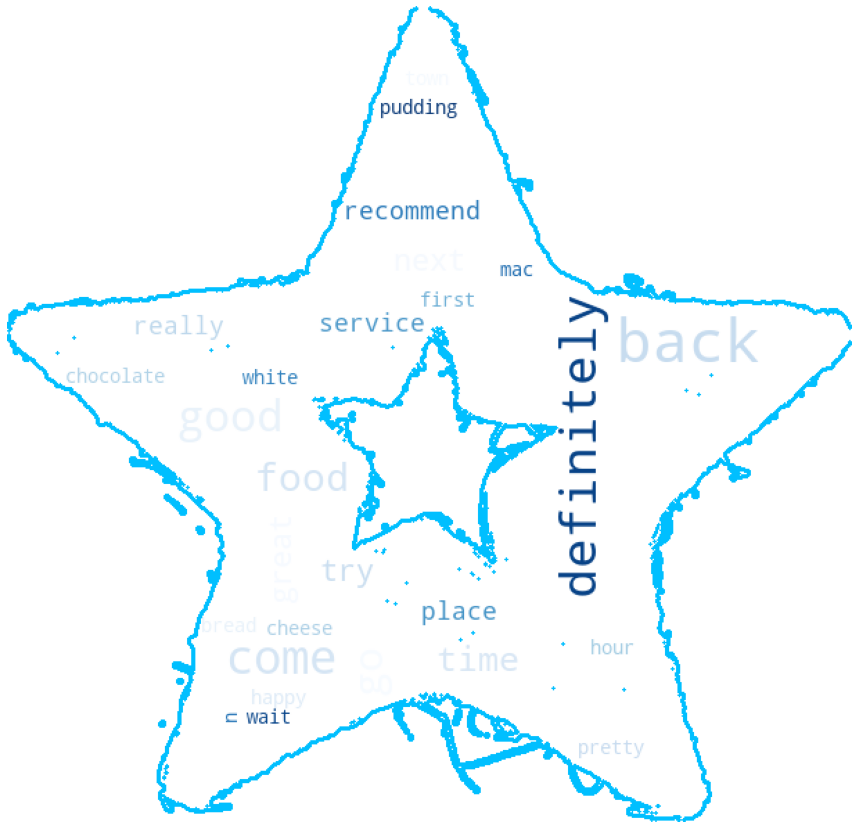


----- 20 most common 2-word phrase -----
really good: 2854
food good: 2658
happy hour: 2532
go back: 2349
good food: 2201
pretty good: 2200
come back: 2121
first time: 2054
next time: 1993
great place: 1933
great food: 1765
food great: 1658
would definitely: 1469
service great: 1412
great service: 1374
service good: 1270
highly recommend: 1244
sweet potato: 1243
good service: 1237
ice cream: 1040

----- 20 most common 3-word phrase -----
definitely go back: 496
definitely come back: 469
would go back: 365
would come back: 365
mac n cheese: 355
would definitely recommend: 352
would definitely go: 309
food really good: 304
come back try: 299
would definitely come: 297
food good service: 279
food great service: 270
go back try: 269
wait go back: 268
food pretty good: 268
seated right away: 264
good food good: 232
back next time: 225
shrimp po boy: 212
one best ever: 201

----- 20 most common 4-word phrase -----
would definitely come back: 242
would definitely go back: 241
would definitel

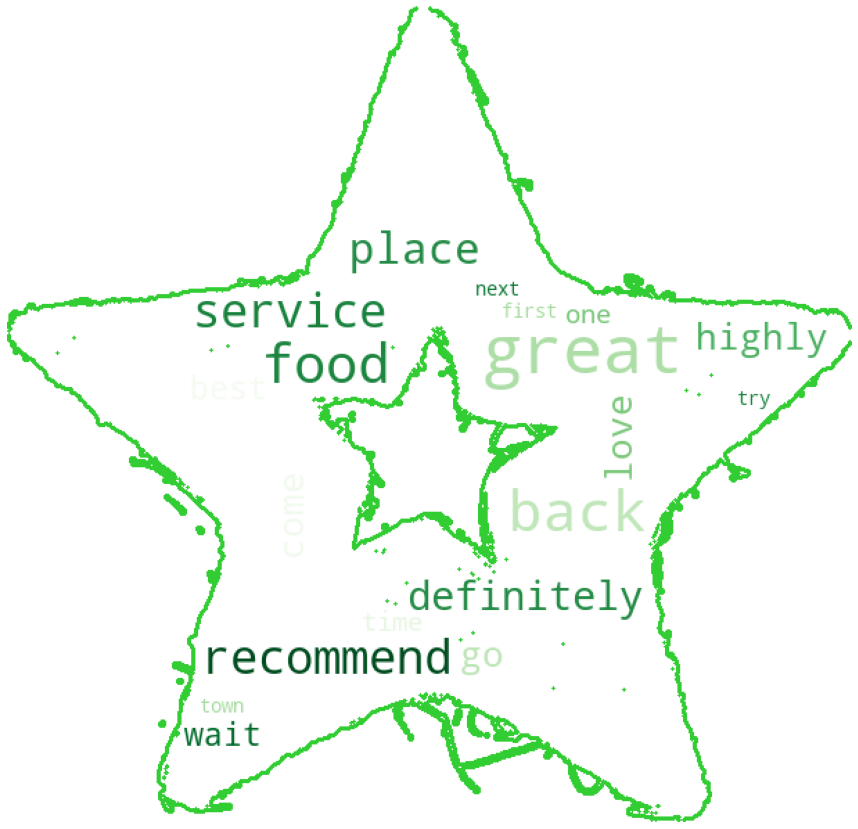


----- 20 most common 2-word phrase -----
highly recommend: 4820
great food: 4752
great service: 3823
food great: 3599
first time: 3521
go back: 3299
come back: 3121
best ever: 3112
one best: 3091
love place: 3015
service great: 2934
great place: 2751
happy hour: 2662
really good: 2617
next time: 2464
food service: 2352
every time: 2221
food amazing: 2197
good food: 2137
definitely back: 2127

----- 20 most common 3-word phrase -----
wait go back: 1095
great food great: 862
food great service: 848
definitely come back: 750
one best ever: 738
would highly recommend: 704
highly recommend place: 699
would definitely recommend: 606
wait come back: 606
service great food: 597
definitely go back: 543
definitely coming back: 539
back next time: 487
mac n cheese: 477
great service great: 462
love love love: 401
staff super friendly: 363
would definitely come: 330
great food service: 324
service top notch: 316

----- 20 most common 4-word phrase -----
great food great service: 352
would definit

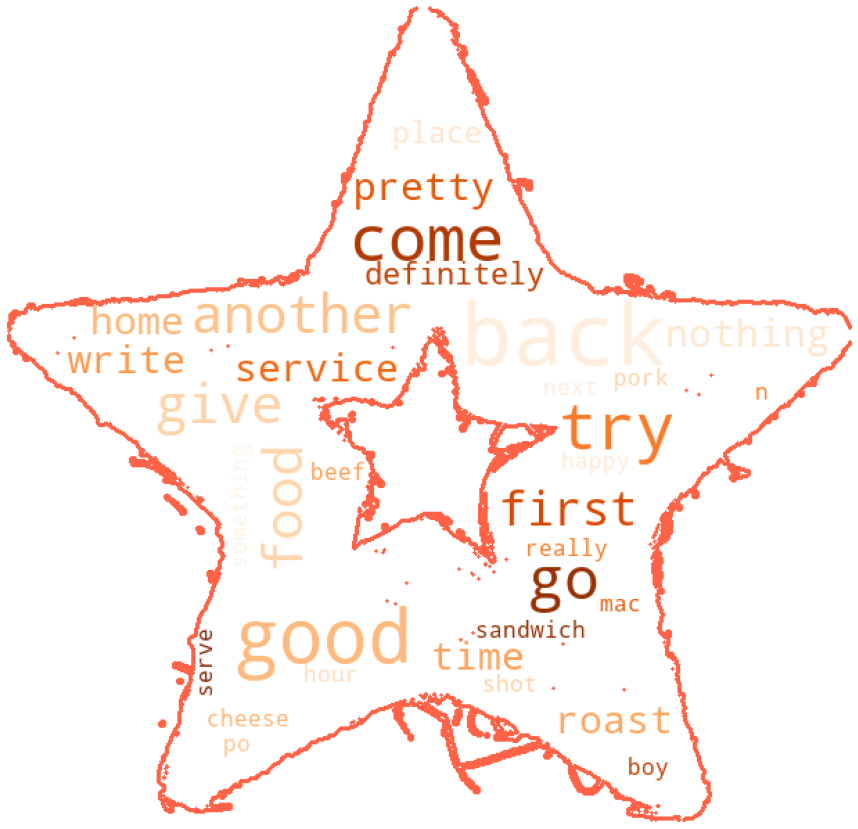


----- 20 most common 2-word phrase -----
food good: 1671
pretty good: 1629
go back: 1405
come back: 1063
really good: 1061
happy hour: 991
first time: 950
good food: 857
next time: 804
service good: 757
nothing special: 657
good service: 575
tasted like: 568
much better: 546
feel like: 524
would go: 518
even though: 516
food service: 513
sweet potato: 507
food great: 505

----- 20 most common 3-word phrase -----
would go back: 277
food pretty good: 219
would come back: 205
mac n cheese: 174
nothing write home: 172
give another try: 150
food good service: 148
go back try: 123
roast pork sandwich: 105
come back try: 104
food really good: 104
shrimp po boy: 102
probably go back: 95
seated right away: 95
service good food: 94
give another shot: 90
definitely go back: 84
try something else: 83
good food good: 81
food great service: 76

----- 20 most common 4-word phrase -----
would definitely go back: 41
give place another try: 38
roast beef po boy: 38
would definitely come back: 33
back t

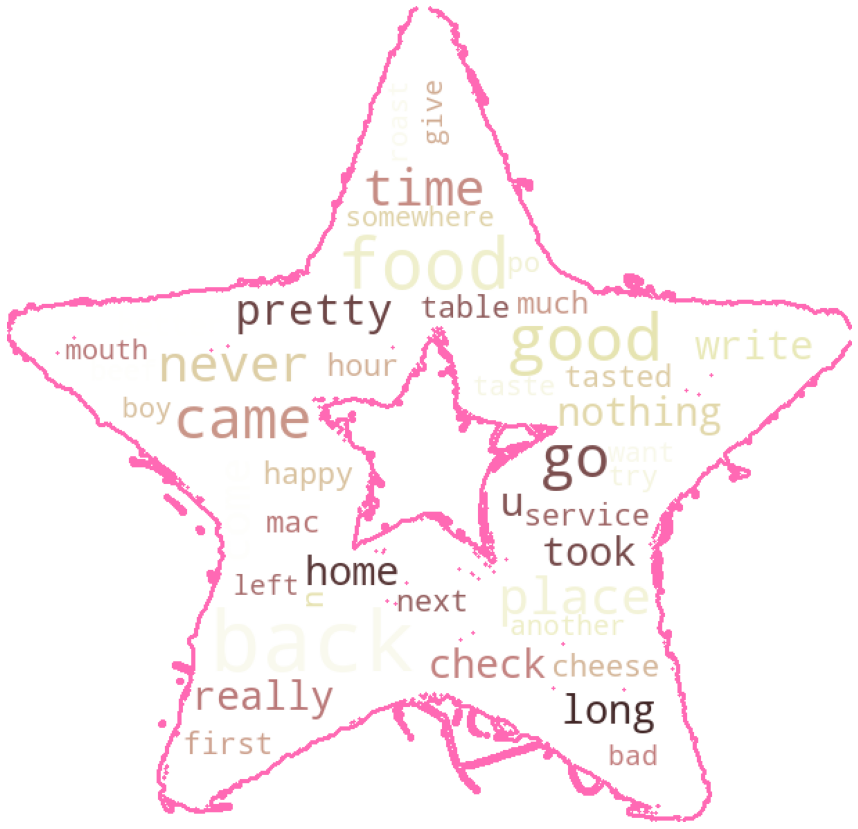


----- 20 most common 2-word phrase -----
food good: 827
go back: 787
first time: 691
tasted like: 671
come back: 579
pretty good: 506
much better: 492
happy hour: 487
good food: 480
came back: 425
food service: 409
nothing special: 384
even though: 383
customer service: 382
really good: 376
last time: 363
good service: 357
service good: 346
going back: 334
long time: 324

----- 20 most common 3-word phrase -----
would go back: 106
nothing write home: 100
food good service: 90
table next u: 89
mac n cheese: 83
would come back: 82
food pretty good: 80
never came back: 72
go somewhere else: 72
really like place: 68
took long time: 67
give another try: 66
food mediocre best: 64
never go back: 61
best part meal: 55
took forever get: 53
really looking forward: 51
seated right away: 50
service good food: 49
shrimp po boy: 48

----- 20 most common 4-word phrase -----
left bad taste mouth: 20
came back check u: 19
really want like place: 19
food took long time: 16
took long time get: 15
food n

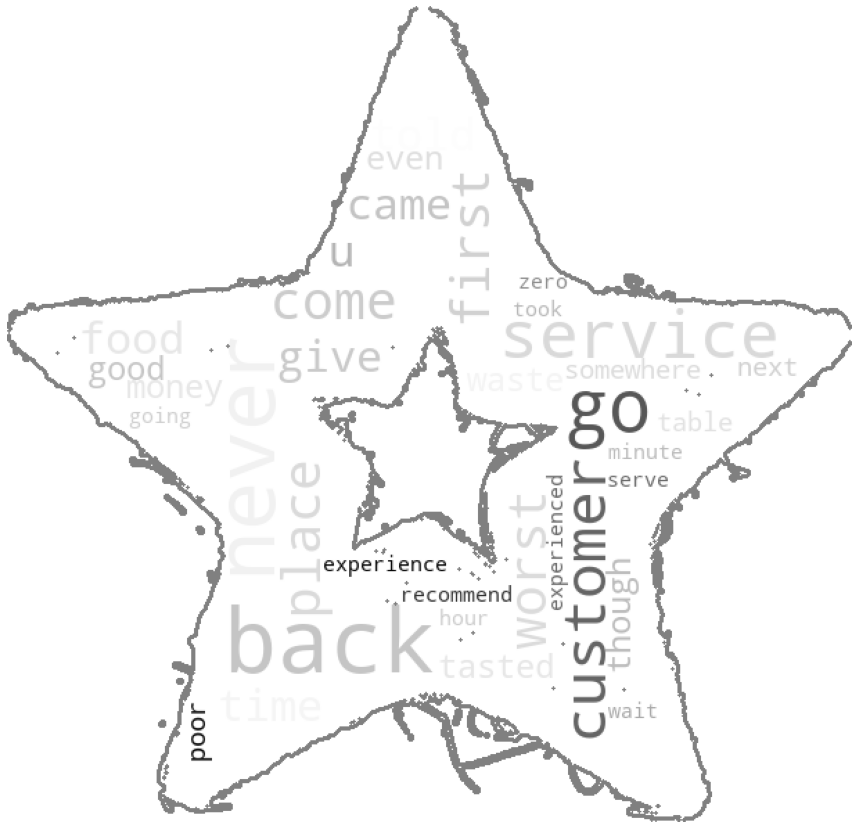


----- 20 most common 2-word phrase -----
customer service: 907
go back: 799
first time: 645
come back: 608
tasted like: 545
came back: 524
food good: 499
told u: 498
even though: 444
never go: 437
going back: 420
waste time: 370
food service: 369
one star: 354
happy hour: 343
last time: 342
last night: 338
much better: 331
get food: 320
long time: 316

----- 20 most common 3-word phrase -----
never go back: 299
waste time money: 135
worst service ever: 120
go somewhere else: 119
never come back: 118
table next u: 94
never came back: 82
poor customer service: 75
worst experience ever: 75
never going back: 75
worst customer service: 74
food mediocre best: 68
never coming back: 65
take drink order: 64
horrible customer service: 63
wish could give: 62
one worst ever: 62
would recommend place: 61
could give zero: 59
recommend place anyone: 59

----- 20 most common 4-word phrase -----
worst customer service ever: 34
could give zero would: 33
would never go back: 32
took hour get food: 25
wo

In [13]:
#%% generate most frequent words for seperate star category 
sample_review = pd.read_csv('sample_review.csv')
reviews = pd.read_csv('sample_review.csv')
review_lst = []
most_frq_wrds_lst = []
for i in reviews.review_stars.unique():
    tic = tm.time()
    review = reviews.loc[(reviews.review_stars == i), 'clean_text']
    most_frq_words = compute_show_frequent(review, i, max_len = 4, n_frq1 = 10, n_frq2 = 20)
    review_lst.append(review)
    most_frq_wrds_lst.append(most_frq_words)
    toc = tm.time()
    print(f"Finish processing {i} stars in {round(toc - tic, 2)} seconds.")

# Review Level Prediction 

In [14]:
# vectorization 
clean_review = sample_review['clean_text']
review_vocab, review_vocab_mtx = get_vocab_mtx(clean_review)

Vectorize the vocabulary in  1 ngrams takes  9.77 seconds.
The length of the vocabulary in reviews is: 
22204
Generate the vocabulary matrix in  1 ngrams takes  8.16 seconds.
Shape of the sparse matrix:  (180968, 22204)
Non-Zero occurences:  6383801
Density of the matrix =  0.15887162403102909


In [15]:
#Categorize ratings to three levels
review_ctg = sample_review['review_stars'].apply(lambda x: 'good' if x >= 4 else 'bad' if x <= 2 else 'neutral')

In [12]:
#Categorize ratings to two levels
review_ctg = sample_review['review_stars'].apply(lambda x: 'good' if x >= 3 else 'bad')

In [16]:
# splitting sample 
x_train, x_test, y_train, y_test = train_test_split(review_vocab_mtx, review_ctg, test_size = .2, random_state = 100)

#print(sample_review.head)

## Method 1: Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
mnb = MultinomialNB()
mnb_nm = "Multinomial Naive Bayes"
mnb_prd = report_prediction(mnb,mnb_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 0.62 seconds to generate  Multinomial Naive Bayes  Classifer.

It takes 0.18 seconds to generate  Multinomial Naive Bayes  prediction.
******************************************************************************
Confusion Matrix for  Multinomial Naive Bayes  Classifier:
[[ 4376   597  1192]
 [  693 26080  1508]
 [  916  1720  1875]]

Score: 82.99

Classification Report:               precision    recall  f1-score   support

         bad       0.73      0.71      0.72      6165
        good       0.92      0.92      0.92     28281
     neutral       0.41      0.42      0.41      4511

    accuracy                           0.83     38957
   macro avg       0.69      0.68      0.68     38957
weighted avg       0.83      0.83      0.83     38957



In [64]:
from sklearn.feature_selection import RFE
# Create a RFE model with 100 features
rfe = RFE(mnb, n_features_to_select=100)

# Fit the RFE model on the training data
rfe.fit(x_train, y_train)


Top 10 features that are most related to low ratings:
Rank: 1, Feature: undiscerning
Rank: 1, Feature: undoable
Rank: 1, Feature: undoubtably
Rank: 1, Feature: unemotional
Rank: 1, Feature: unexplainably
Rank: 1, Feature: unfinishable
Rank: 1, Feature: unflattering
Rank: 1, Feature: ungraciously
Rank: 1, Feature: ungratefulness
Rank: 1, Feature: unhealthiness


In [65]:
# Get the top 10 low rating features
top_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), review_vocab.get_feature_names()))
print("Top 10 features that are most related to low ratings:")
for rank, feature in top_features[:10]:
    print(f"Rank: {rank}, Feature: {feature}")

Top 10 features that are most related to low ratings:
Rank: 1, Feature: undiscerning
Rank: 1, Feature: undoable
Rank: 1, Feature: undoubtably
Rank: 1, Feature: unemotional
Rank: 1, Feature: unexplainably
Rank: 1, Feature: unfinishable
Rank: 1, Feature: unflattering
Rank: 1, Feature: ungraciously
Rank: 1, Feature: ungratefulness
Rank: 1, Feature: unhealthiness


## Method 2: Decision Tree 

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_nm = "Decision Tree"
dt_prd = report_prediction(dt, dt_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 314.93 seconds to generate  Decision Tree  Classifer.

It takes 0.05 seconds to generate  Decision Tree  prediction.
******************************************************************************
Confusion Matrix for  Decision Tree  Classifier:
[[ 3131  1587   991]
 [ 1377 22933  1919]
 [ 1061  2241   954]]

Score: 74.65

Classification Report:               precision    recall  f1-score   support

         bad       0.56      0.55      0.56      5709
        good       0.86      0.87      0.87     26229
     neutral       0.25      0.22      0.23      4256

    accuracy                           0.75     36194
   macro avg       0.56      0.55      0.55     36194
weighted avg       0.74      0.75      0.74     36194



## Method 3: K Nearest Neighbour 

In [18]:
# Method 3: K Nearest Neighbour 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn_nm = "K Nearest Neighbour"
knn_prd = report_prediction(knn, knn_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 0.27 seconds to generate  K Nearest Neighbour  Classifer.

It takes 301.5 seconds to generate  K Nearest Neighbour  prediction.
******************************************************************************
Confusion Matrix for  K Nearest Neighbour  Classifier:
[[  958  4627   124]
 [   89 26056    84]
 [  189  3967   100]]

Score: 74.91

Classification Report:               precision    recall  f1-score   support

         bad       0.78      0.17      0.28      5709
        good       0.75      0.99      0.86     26229
     neutral       0.32      0.02      0.04      4256

    accuracy                           0.75     36194
   macro avg       0.62      0.39      0.39     36194
weighted avg       0.71      0.75      0.67     36194



## Method 4: Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr_nm = "Random Forest"
rmfr_prd = report_prediction(rmfr, rmfr_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 3225.01 seconds to generate  Random Forest  Classifer.

It takes 5.58 seconds to generate  Random Forest  prediction.
******************************************************************************
Confusion Matrix for  Random Forest  Classifier:
[[ 3070  2609    30]
 [  135 26075    19]
 [  520  3675    61]]

Score: 80.69

Classification Report:               precision    recall  f1-score   support

         bad       0.82      0.54      0.65      5709
        good       0.81      0.99      0.89     26229
     neutral       0.55      0.01      0.03      4256

    accuracy                           0.81     36194
   macro avg       0.73      0.52      0.52     36194
weighted avg       0.78      0.81      0.75     36194



## Method 5: Gradient Bossting 

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
"""# parameter evaluation
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)"""

gbi = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, max_features = 0.5, random_state = 100)
gbi_nm = "Gradient Bossting"
gbi_prd = report_prediction(gbi, gbi_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 885.94 seconds to generate  Gradient Bossting  Classifer.

It takes 0.45 seconds to generate  Gradient Bossting  prediction.
******************************************************************************
Confusion Matrix for  Gradient Bossting  Classifier:
[[ 3119  2180   410]
 [  201 25731   297]
 [  596  3014   646]]

Score: 81.49

Classification Report:               precision    recall  f1-score   support

         bad       0.80      0.55      0.65      5709
        good       0.83      0.98      0.90     26229
     neutral       0.48      0.15      0.23      4256

    accuracy                           0.81     36194
   macro avg       0.70      0.56      0.59     36194
weighted avg       0.78      0.81      0.78     36194



## Method 6: XGboost

In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb = XGBClassifier()
xgb_nm ="XGboost"
xgb_prd = report_prediction(xgb, xgb_nm, x_train, x_test, y_train_encoded, y_test_encoded)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 149.62 seconds to generate  XGboost  Classifer.

It takes 0.4 seconds to generate  XGboost  prediction.
******************************************************************************
Confusion Matrix for  XGboost  Classifier:
[[ 3752  1470   487]
 [  285 25543   401]
 [  791  2646   819]]

Score: 83.2

Classification Report:               precision    recall  f1-score   support

           0       0.78      0.66      0.71      5709
           1       0.86      0.97      0.91     26229
           2       0.48      0.19      0.27      4256

    accuracy                           0.83     36194
   macro avg       0.71      0.61      0.63     36194
weighted avg       0.80      0.83      0.81     36194



## Method 7: Support Vector Machine 

In [36]:
from sklearn.svm import SVC
svm = SVC(random_state = 100)
svm_nm = "Support Vector Machine"
svm_prd = report_prediction(svm, svm_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 22857.65 seconds to generate  Support Vector Machine  Classifer.

It takes 1162.41 seconds to generate  Support Vector Machine  prediction.
******************************************************************************
Confusion Matrix for  Support Vector Machine  Classifier:
[[ 4599  1144   422]
 [  321 27660   300]
 [  925  2670   916]]

Score: 85.16

Classification Report:               precision    recall  f1-score   support

         bad       0.79      0.75      0.77      6165
        good       0.88      0.98      0.93     28281
     neutral       0.56      0.20      0.30      4511

    accuracy                           0.85     38957
   macro avg       0.74      0.64      0.66     38957
weighted avg       0.83      0.85      0.83     38957



## Method 8: Logistic Regression 

In [22]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr_nm = "Logistic Regression " 
lgr_prd = report_prediction(lgr,lgr_nm, x_train, x_test, y_train, y_test)

/Users/garlicfish/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 38.32 seconds to generate  Logistic Regression   Classifer.

It takes 0.13 seconds to generate  Logistic Regression   prediction.
******************************************************************************
Confusion Matrix for  Logistic Regression   Classifier:
[[ 4219   832   658]
 [  355 25099   775]
 [  990  2062  1204]]

Score: 84.33

Classification Report:               precision    recall  f1-score   support

         bad       0.76      0.74      0.75      5709
        good       0.90      0.96      0.93     26229
     neutral       0.46      0.28      0.35      4256

    accuracy                           0.84     36194
   macro avg       0.70      0.66      0.67     36194
weighted avg       0.82      0.84      0.83     36194



##  Method 9: Multilayer Perception Classifier

In [32]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp_nm = "Multilayer Perception"
mlp_prd = report_prediction(mlp, mlp_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 5483.07 seconds to generate  Multilayer Perception  Classifer.

It takes 0.32 seconds to generate  Multilayer Perception  prediction.
******************************************************************************
Confusion Matrix for  Multilayer Perception  Classifier:
[[ 4586   628   951]
 [  562 26288  1431]
 [ 1074  1887  1550]]

Score: 83.23

Classification Report:               precision    recall  f1-score   support

         bad       0.74      0.74      0.74      6165
        good       0.91      0.93      0.92     28281
     neutral       0.39      0.34      0.37      4511

    accuracy                           0.83     38957
   macro avg       0.68      0.67      0.68     38957
weighted avg       0.82      0.83      0.83     38957



# Restaurant Level Prediction

In [23]:
# load data 
all_review = pd.read_csv('all_review_1.csv')
tic = tm.time()
restaurant_reviews = all_review.groupby(['business_id', "stars"], as_index = False).agg({'clean_text': ' '.join} )
toc = tm.time()
print(f"It takes {round(toc - tic, 2)} seconds to concatenate clean text by restaurants.")
restaurant_reviews.stars.describe()
clean_reviews = restaurant_reviews['clean_text']

It takes 6.76 seconds to concatenate clean text by restaurants.


In [24]:
# vocabulary vectorization  
review_vocab, review_vocab_mtx = get_vocab_mtx(data = clean_reviews, f = TfidfVectorizer)

Vectorize the vocabulary in  1 ngrams takes  68.6 seconds.
The length of the vocabulary in reviews is: 
36592
Generate the vocabulary matrix in  1 ngrams takes  70.74 seconds.
Shape of the sparse matrix:  (3039, 36592)
Non-Zero occurences:  8281928
Density of the matrix =  7.447570161001285


In [25]:
# splitting sample 
review_ctg = restaurant_reviews['stars'].apply(lambda x: 'good' if x > 4 else 'bad' if x <= 3 else 'neutral')

In [ ]:
review_ctg = restaurant_reviews['stars'].apply(lambda x: 'good' if x >= 4 else 'bad')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(review_vocab_mtx, review_ctg, test_size = .2, random_state = 100)

## Method 1: Multinomial Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb_nm = "Multinomial Naive Bayes"
mnb_prd = report_prediction(mnb,mnb_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 1.1 seconds to generate  Multinomial Naive Bayes  Classifer.

It takes 0.09 seconds to generate  Multinomial Naive Bayes  prediction.
******************************************************************************
Confusion Matrix for  Multinomial Naive Bayes  Classifier:
[[ 4000   569  1140]
 [  742 23890  1597]
 [  896  1619  1741]]

Score: 81.87

Classification Report:               precision    recall  f1-score   support

         bad       0.71      0.70      0.71      5709
        good       0.92      0.91      0.91     26229
     neutral       0.39      0.41      0.40      4256

    accuracy                           0.82     36194
   macro avg       0.67      0.67      0.67     36194
weighted avg       0.82      0.82      0.82     36194



## Mehod 2: Logistic Regression 

In [27]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr_nm = "Logistic Regression " 
lgr_prd = report_prediction(lgr,lgr_nm, x_train, x_test, y_train, y_test)

/Users/garlicfish/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 25.03 seconds to generate  Logistic Regression   Classifer.

It takes 0.02 seconds to generate  Logistic Regression   prediction.
******************************************************************************
Confusion Matrix for  Logistic Regression   Classifier:
[[ 4219   832   658]
 [  355 25099   775]
 [  990  2062  1204]]

Score: 84.33

Classification Report:               precision    recall  f1-score   support

         bad       0.76      0.74      0.75      5709
        good       0.90      0.96      0.93     26229
     neutral       0.46      0.28      0.35      4256

    accuracy                           0.84     36194
   macro avg       0.70      0.66      0.67     36194
weighted avg       0.82      0.84      0.83     36194



## Method 3: Decision Tree 

In [28]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_nm = "Decision Tree"
dt_prd = report_prediction(dt, dt_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 332.82 seconds to generate  Decision Tree  Classifer.

It takes 0.1 seconds to generate  Decision Tree  prediction.
******************************************************************************
Confusion Matrix for  Decision Tree  Classifier:
[[ 3147  1574   988]
 [ 1388 22915  1926]
 [ 1044  2258   954]]

Score: 74.64

Classification Report:               precision    recall  f1-score   support

         bad       0.56      0.55      0.56      5709
        good       0.86      0.87      0.87     26229
     neutral       0.25      0.22      0.23      4256

    accuracy                           0.75     36194
   macro avg       0.56      0.55      0.55     36194
weighted avg       0.74      0.75      0.74     36194



## Method 4: K Nearest Neighbour 

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 10)
knn_nm = "K Nearest Neighbour"
knn_prd = report_prediction(knn, knn_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 0.41 seconds to generate  K Nearest Neighbour  Classifer.

It takes 427.23 seconds to generate  K Nearest Neighbour  prediction.
******************************************************************************
Confusion Matrix for  K Nearest Neighbour  Classifier:
[[  958  4627   124]
 [   89 26056    84]
 [  189  3967   100]]

Score: 74.91

Classification Report:               precision    recall  f1-score   support

         bad       0.78      0.17      0.28      5709
        good       0.75      0.99      0.86     26229
     neutral       0.32      0.02      0.04      4256

    accuracy                           0.75     36194
   macro avg       0.62      0.39      0.39     36194
weighted avg       0.71      0.75      0.67     36194



## Method 5: Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr_nm = "Random Forest"
rmfr_prd = report_prediction(rmfr, rmfr_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 791.21 seconds to generate  Random Forest  Classifer.

It takes 4.57 seconds to generate  Random Forest  prediction.
******************************************************************************
Confusion Matrix for  Random Forest  Classifier:
[[ 3019  2659    31]
 [  127 26092    10]
 [  532  3670    54]]

Score: 80.58

Classification Report:               precision    recall  f1-score   support

         bad       0.82      0.53      0.64      5709
        good       0.80      0.99      0.89     26229
     neutral       0.57      0.01      0.02      4256

    accuracy                           0.81     36194
   macro avg       0.73      0.51      0.52     36194
weighted avg       0.78      0.81      0.75     36194



## Method 6: Gradient Boosting 

In [31]:
from sklearn.ensemble import GradientBoostingClassifier 
#from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for an estimator.
# parameter evaluation
#gbe = GradientBoostingClassifier(random_state = 0)
#parameters = {
#     'learning_rate': [0.05, 0.1, 0.5],
#    'max_features': [0.5, 1],
#    'max_depth': [3, 4, 5]}
#gbs_gs = GridSearchCV(gbe, parameters, cv = 3, scoring = 'roc_auc', n_jobs = -1) # use all processors 
#tic = tm.time()
#gbs_gs.fit(x_train, y_train)
#toc = tm.ime()
#print("It takes", round(toc - tic, 2), "seconds to finish grid search.")
#sorted(gbs_gs.cv_results_.keys())
#print(gbs_gs.best_params_)
#print(gbs_gs.best_score_)

gbi = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, max_features = 0.5, random_state = 100)
gbi_nm = "Gradient Bossting"
gbi_prd = report_prediction(gbi, gbi_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 1769.01 seconds to generate  Gradient Bossting  Classifer.

It takes 0.76 seconds to generate  Gradient Bossting  prediction.
******************************************************************************
Confusion Matrix for  Gradient Bossting  Classifier:
[[ 3119  2180   410]
 [  201 25731   297]
 [  596  3014   646]]

Score: 81.49

Classification Report:               precision    recall  f1-score   support

         bad       0.80      0.55      0.65      5709
        good       0.83      0.98      0.90     26229
     neutral       0.48      0.15      0.23      4256

    accuracy                           0.81     36194
   macro avg       0.70      0.56      0.59     36194
weighted avg       0.78      0.81      0.78     36194



## Method 7: XGboost 

In [32]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb = XGBClassifier()
xgb_nm ="XGboost"
xgb_prd = report_prediction(xgb, xgb_nm, x_train, x_test, y_train_encoded, y_test_encoded)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 169.99 seconds to generate  XGboost  Classifer.

It takes 0.34 seconds to generate  XGboost  prediction.
******************************************************************************
Confusion Matrix for  XGboost  Classifier:
[[ 3752  1470   487]
 [  285 25543   401]
 [  791  2646   819]]

Score: 83.2

Classification Report:               precision    recall  f1-score   support

           0       0.78      0.66      0.71      5709
           1       0.86      0.97      0.91     26229
           2       0.48      0.19      0.27      4256

    accuracy                           0.83     36194
   macro avg       0.71      0.61      0.63     36194
weighted avg       0.80      0.83      0.81     36194



## Method 8: Multilayer Perception Classifier

In [33]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp_nm = "Multilayer Perception"
mlp_prd = report_prediction(mlp, mlp_nm, x_train, x_test, y_train, y_test)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 4715.26 seconds to generate  Multilayer Perception  Classifer.

It takes 0.3 seconds to generate  Multilayer Perception  prediction.
******************************************************************************
Confusion Matrix for  Multilayer Perception  Classifier:
[[ 4145   702   862]
 [  526 24275  1428]
 [ 1018  1857  1381]]

Score: 82.34

Classification Report:               precision    recall  f1-score   support

         bad       0.73      0.73      0.73      5709
        good       0.90      0.93      0.91     26229
     neutral       0.38      0.32      0.35      4256

    accuracy                           0.82     36194
   macro avg       0.67      0.66      0.66     36194
weighted avg       0.81      0.82      0.82     36194



## Method 9: Support Vector Machine 

In [ ]:
from sklearn.svm import SVC
svm = SVC(random_state = 100)
svm_nm = "Support Vector Machine"
svm_prd = report_prediction(svm, svm_nm, x_train, x_test, y_train, y_test) # takes about 7 hours 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
It takes 74402.3 seconds to generate  Support Vector Machine  Classifer.
